In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
#前処理ライブラリ
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel

#評価ライブラリ
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'MS Gothic'  
import seaborn as sns
from scipy.stats import randint,uniform
from keras_tuner import RandomSearch
from sklearn.metrics import mean_squared_error
import shap
from sklearn.model_selection import RandomizedSearchCV


#モデル
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

basemodel=RandomForestRegressor(n_estimators=100, random_state=0)
model1=LGBMRegressor(n_estimators=100, random_state=0)

#読み込みデータ
Xt=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
Y=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

#目的変数
target="SalePrice"

In [3]:
#データ確認1
def check_data(df1,df2=None):

    print(df1.info())

    if df2 is not None:
        print(df2.info())


check_data(Xt)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#データ前々処理

def Clean_data(df,threshold_rate=None):

    #閾値
    if threshold_rate is not None:
        #デフォルト：index数/カスタム
        threshold = len(df) / threshold_rate
    else:
        #デフォルト：index数/3
        threshold = len(df) / 3

    print(f"切り捨て欠損値数_閾値: {threshold:.1f}")
    # 欠損数が閾値以上の列を削除
    df = df.dropna(axis=1, thresh=len(df) - threshold)
    return df

N_Xt=Clean_data(Xt,threshold_rate=10)
N_Xt.info()

切り捨て欠損値数_閾値: 146.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   in

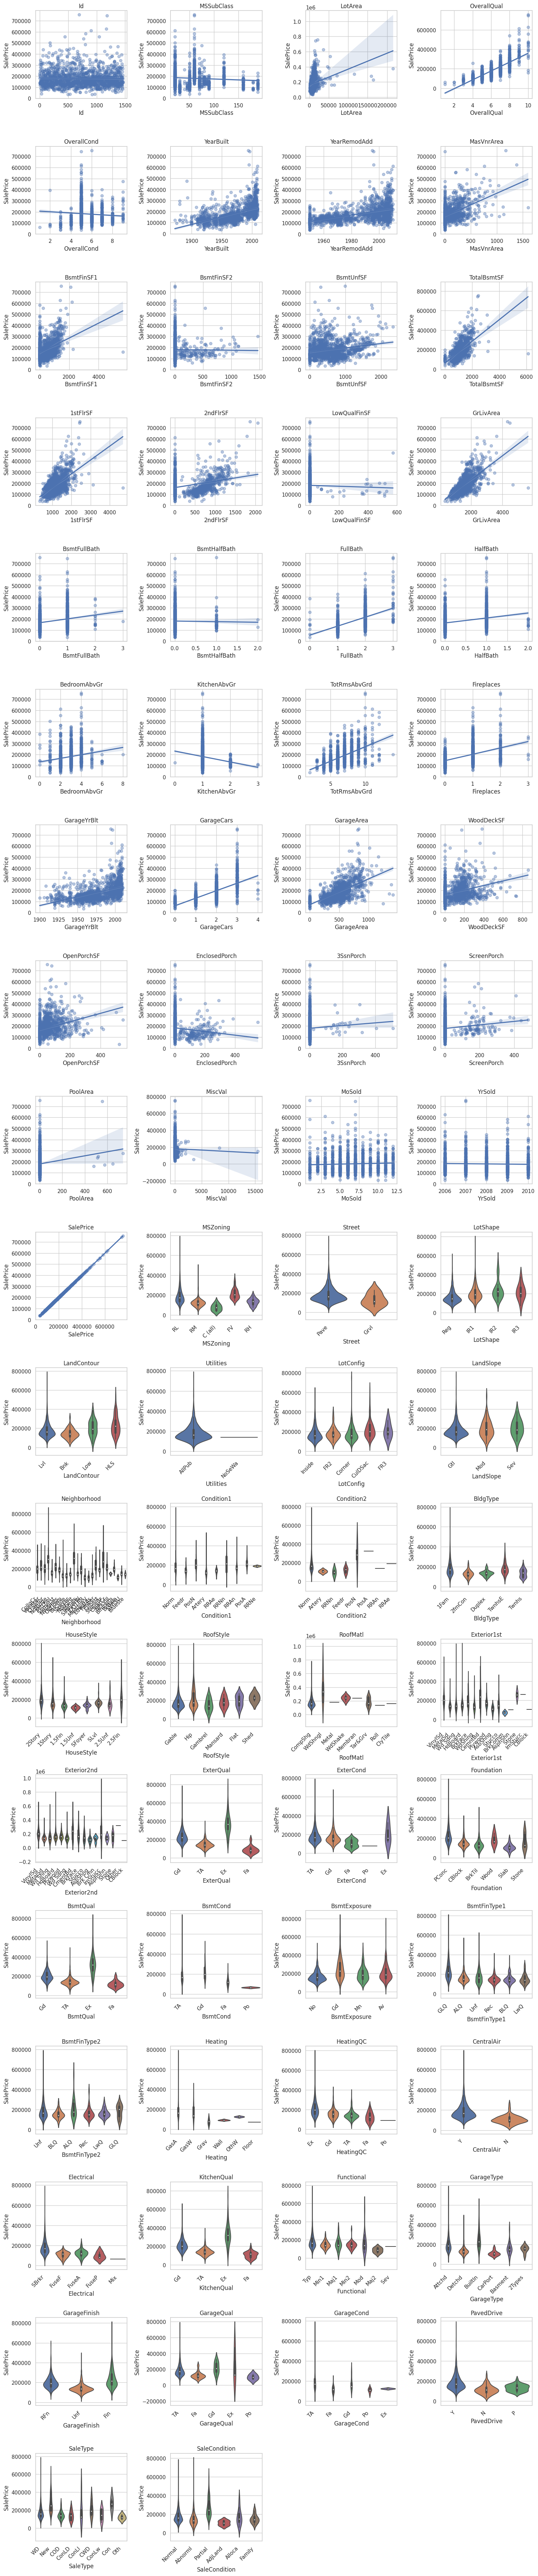

In [5]:
def plot_column_distributions(df,Y, max_cols=4, figsize=(16, 4), bins=30):
    """
    データフレームのすべての列の分布を一括でグリッド表示する。
    数値列は散布図、カテゴリ列はバイオリンプロット。
    """
    sns.set(style="whitegrid")
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'bool', 'category']).columns
    
    all_cols = list(num_cols) + list(cat_cols)
    total = len(all_cols)
    rows = (total + max_cols - 1) // max_cols
    
    fig, axes = plt.subplots(rows, max_cols, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten()

    for i, col in enumerate(all_cols):
        ax = axes[i]
        if col in num_cols:
            sns.regplot(x=col,y=df[Y],data=df, scatter_kws={'alpha':0.4},ax=ax)
        else:
            sns.violinplot(x=col,y=df[Y], data=df,ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_title(col)
    
    # 不要な軸を非表示
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_column_distributions(N_Xt,target)

In [6]:
y = N_Xt[target]
X=N_Xt
X=X.drop([target], axis=1)

xtr,xval,ytr,yval=train_test_split(X,y,test_size=0.2,random_state=0)

# ==== 特徴量分類 ====
cat_cols=[cname for cname in xtr.columns if xtr[cname].dtype == "object"]
num_cols =[cname for cname in xtr.columns if xtr[cname].dtype in ['int64', 'float64']]    
    
def model_set(model,xtr,ytr,num_cols,cat_cols):
    
    # ==== 前処理 ====
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    prep = ColumnTransformer(transformers=[
            ('num',numeric_transformer , num_cols),
            ('cat',categorical_transformer , cat_cols)
        ])
    
    # ==== 特徴量選択器 ====
    #feature_selector = SelectFromModel(
    #    XGBRegressor(n_estimators=100, random_state=0),
    #    threshold=0.01  # importance > 0.01 を選択
    #)
    
    pip = Pipeline(steps=[
        ("preprocessor", prep),
        #"feature_selector", feature_selector),
        ("model", model)
    ])
    
    # ==== 学習 ====
    trained_model=pip.fit(xtr, ytr)
    return trained_model

trained_model=model_set(basemodel,xtr,ytr,num_cols,cat_cols)

In [7]:
ypred=trained_model.predict(xval)
rmse = mean_squared_error(yval, ypred, squared=False)
print(f"📏 RMSE（Root Mean Squared Error）: {rmse:.4f}")

📏 RMSE（Root Mean Squared Error）: 34207.9456


 98%|===================| 1147/1168 [00:49<00:00]       

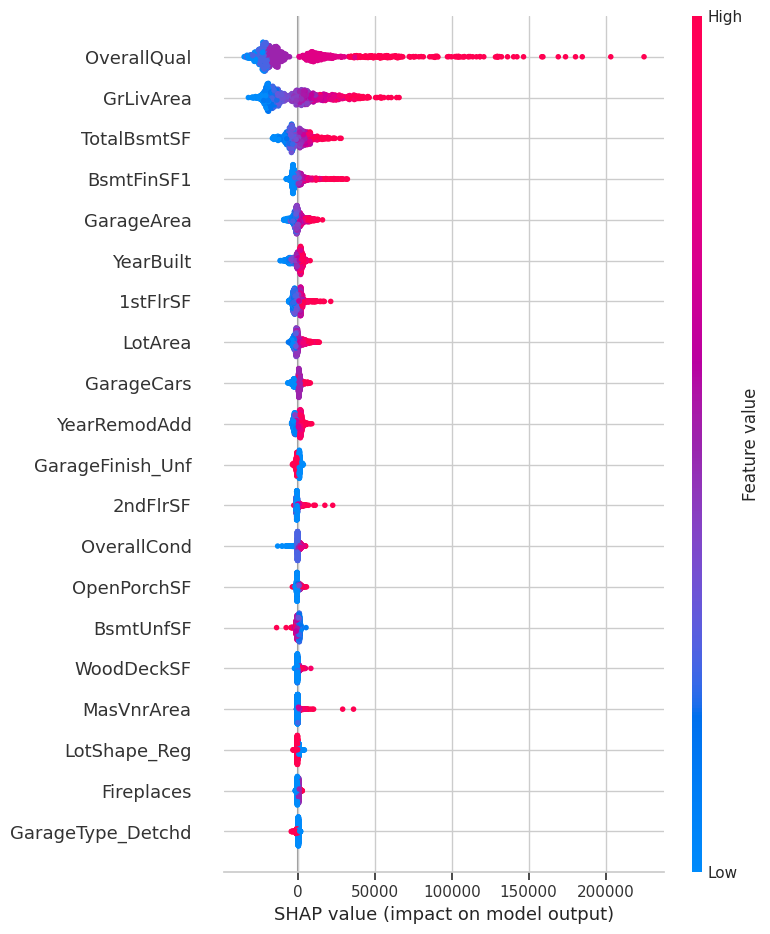

In [8]:
def Shap_Analysis(trained_model,xtr,ytr,num_cols,cat_cols):
    # Step 1: 前処理のみ適用
    preprocessor = trained_model.named_steps["preprocessor"]
    model = trained_model.named_steps["model"]
    
    # X_train を前処理後の NumPy 配列に変換
    X_transformed = preprocessor.transform(xtr)
    
    # sparse → dense 変換（OneHotEncoderの出力が疎行列になるため）
    if hasattr(X_transformed, "toarray"):
        X_transformed = X_transformed.toarray()
    
    # 特徴量名を取得
    # 数値列 + OneHot後のカテゴリ列名を結合
    num_features = num_cols
    cat_features = list(trained_model.named_steps["preprocessor"]
                        .named_transformers_["cat"]
                        .named_steps["onehot"]
                        .get_feature_names_out(cat_cols))
    all_features = num_features + cat_features
    
    # Step 2: SHAP explainer 作成
    explainer = shap.Explainer(model, X_transformed)
    shap_values = explainer(X_transformed, check_additivity=False)
    
    # Step 3: SHAP値計算
    #shap_values = explainer(X_transformed)
    
    # Step 4: 可視化
    return shap.summary_plot(shap_values, features=X_transformed, feature_names=all_features)

Shap_Analysis(trained_model,xtr,ytr,num_cols,cat_cols)

In [9]:
#ハイパーパラメータチューニング

# ハイパーパラメータの範囲
param_dist = {
    'model__n_estimators': np.arange(50, 300, 50),
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]}
    
# ランダムサーチ
random_search = RandomizedSearchCV(
    estimator=trained_model,
    param_distributions=param_dist,
    n_iter=50,  # 試行回数
    cv=4,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=0
)

# 探索実行
random_search.fit(xtr, ytr)

# 最適なパラメータとスコア
print("探索結果:", random_search.best_params_)
print("ベストスコア:", random_search.best_score_)
param=random_search.best_params_
tuned_params = {key.replace('model__', ''): value for key, value in param.items()}

探索結果: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 20}
ベストスコア: -29513.98368199894


In [10]:
basemodel = RandomForestRegressor
trained_model_tuned=model_set(basemodel(**tuned_params,random_state=0),xtr,ytr,num_cols,cat_cols)

trained_model_tuned.fit(xtr,ytr)
preds_tuned=trained_model_tuned.predict(Y)

#提出ファイルの保存
output = pd.DataFrame({'Id': Y.Id,
                       'SalePrice': preds_tuned})
output.to_csv('submission.csv', index=False)